## Assignment 5: Using a Plain RNN Model to Predict IBM Stock Prices

Name: Qichun Yu

1. Create a new Jupyter notebook and import the necessary libraries. From Keras, you will need to import all the necessary layers for employing plain RNNs (SimpleRNN, Activation, Dropout, Dense, and Reshape) and 1D convolutions (Conv1D). Also, import mean_squared_error.

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Activation, Dropout, Dense, Reshape, Conv1D, Flatten
from sklearn.metrics import mean_squared_error

2. Load the csv file into a dataframe, reverse the index, and plot the time series (the Close column) for visual inspection. Describe the plot. The csv file is attached to the assignment dropbox.

In [2]:
# load the csv into a dataframe
inp0 = pd.read_csv("IBM.csv")
inp0.head()

,Date,Close,Volume,Open,High,Low
0,1/24/2020,140.56,5580189,143.39,143.9200,140.46
1,1/23/2020,142.87,5657790,144.20,144.4097,142.15
2,1/22/2020,143.89,16470430,143.32,145.7900,142.55
3,1/21/2020,139.17,7244079,137.81,139.3500,137.60
4,1/17/2020,138.31,5623336,136.54,138.3300,136.16


In [3]:
# reverse the index
inp0 = inp0.sort_index(ascending=False)
inp0.head()

,Date,Close,Volume,Open,High,Low
2517,1/25/2010,126.12,5738455,126.33,126.895,125.71
2516,1/26/2010,125.75,7135190,125.92,127.750,125.41
2515,1/27/2010,126.33,8719147,125.82,126.960,125.04
2514,1/28/2010,123.75,9616132,127.03,127.040,123.05
2513,1/29/2010,122.39,11571890,124.32,125.000,121.90


/home/qichun/anaconda3/envs/DL/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


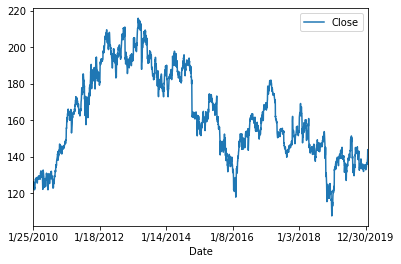

In [4]:
# plot the time series (the 'Close' column)
inp0.plot("Date", "Close")
plt.show()

__Comment:__<br>
The plot has an upward trend between 2010 to 2013. The stock price is going down between 2013 to 2016. The trend of IBM stock is going upward from 2016 to 2017. The price of the stock is moving downward from 2017 to the beginning of 2019. The price tends to go upward again in 2019. 


3. Extract the values for Close from the DataFrame as a numpy array and plot them using matplotlib. What is represented by the x-axis in this plot?

In [5]:
inp0.Close.values

array([126.12, 125.75, 126.33, ..., 143.89, 142.87, 140.56])

In [6]:
#reshape to specify one column
ts_data = inp0.Close.values.reshape(-1,1)

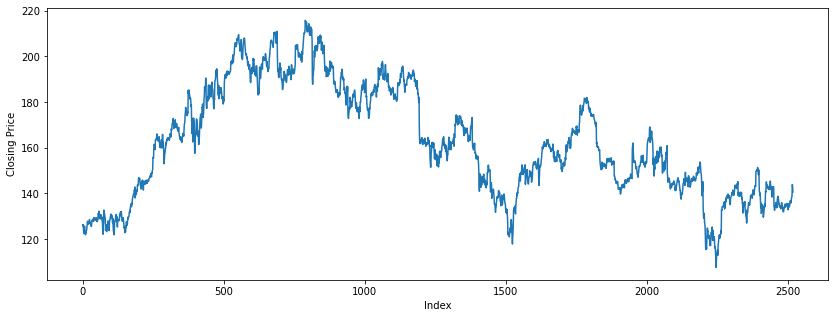

In [7]:
# plot the reshape Close values
plt.figure(figsize=[14,5])
plt.plot(ts_data)
plt.ylabel('Closing Price')
plt.xlabel('Index')
plt.show()

__Comment:__<br>
The X-axis representing the index of the dailt IBM stock price. 

4. Assign the final 25% data as test data and the first 75% as train data.

In [8]:
# calculate the len of 75% of data
train_recs = int(len(ts_data) * 0.75)

In [9]:
# separate the sets
train_data = ts_data[:train_recs]
test_data = ts_data[train_recs:]
len(train_data), len(test_data)

(1888, 630)

5. Using MinMaxScaler from sklearn, scale the train and test data.

In [10]:
# Using the MinMacScaler scales the data so that it is in a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

6. Using the get_lookback function we defined in this chapter (refer to the Preparing the Data for Stock Price Prediction section), get lookback data for the train and test data using a lookback period of 15.

In [11]:
def get_lookback(inp, look_back):
    y = pd.DataFrame(inp)
    dataX = [y.shift(i) for i in range(1, look_back+1)]
    dataX = pd.concat(dataX, axis=1)
    dataX.fillna(0, inplace = True)
    return dataX.values, y.values

In [12]:
# set lookback period of 15
look_back = 15
trainX, trainY = get_lookback(train_scaled, look_back=look_back)
testX, testY = get_lookback(test_scaled, look_back=look_back)
trainX.shape, testX.shape

((1888, 15), (630, 15))

7. Build a model with a 1D convolution layer (5 filters of size 3) and an RNN layer with 32 neurons. Add 25% dropout after the RNN layer. Print the model's summary.

In [13]:
# Instantiate the Sequential model
model = Sequential()

In [14]:
# Add a Reshape layer to get the data in the format(look_back,1)
model.add(Reshape((look_back,1), input_shape = (look_back,)))

In [15]:
# Add a 1D convolution layer(5 filters of size 3)
model.add(Conv1D(5,3, activation='relu'))

In [16]:
# Add a SimpleRNN layer with 32 neurons
model.add(SimpleRNN(32))

In [17]:
# Add a 25% dropout
model.add(Dropout(0.25))

In [18]:
# Add a Dense layer of size 1
model.add(Dense(1))

In [19]:
# Add an activation layer with a linear activation
model.add(Activation('linear'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 15, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 5)             20        
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,269
Trainable params: 1,269
Non-trainable params: 0
______________________________________________________

8. Compile the model with the mean_squared_error loss and the adam optimizer. Fit this on the train data in five epochs with a validation split of 10% and a batch size of 1.

In [21]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2, validation_split=0.1)

Train on 1699 samples, validate on 189 samples
Epoch 1/5
1699/1699 - 4s - loss: 0.0096 - val_loss: 8.8621e-04
Epoch 2/5
1699/1699 - 3s - loss: 0.0042 - val_loss: 5.2981e-04
Epoch 3/5
1699/1699 - 3s - loss: 0.0032 - val_loss: 7.4391e-04
Epoch 4/5
1699/1699 - 3s - loss: 0.0026 - val_loss: 8.0600e-04
Epoch 5/5
1699/1699 - 4s - loss: 0.0022 - val_loss: 9.3529e-04


9. Using the get_model_perf method, print the RMSE of the model.

In [23]:
import math
def get_model_pref(model_obj):
    score_train = model_obj.evaluate(trainX, trainY, verbose=0)
    print('Train RMSE: %.2f RMSE' % (math.sqrt(score_train)))
    score_test = model_obj.evaluate(testX, testY, verbose=0)
    print('Test RMSE: %.2f RMSE' % (math.sqrt(score_test)))

In [24]:
get_model_pref(model)

Train RMSE: 0.05 RMSE
Test RMSE: 0.04 RMSE


10. Find and plot the predictions -- the entire view, as well as a zoomed-in one for a close assessment of the performance. Use the plot to discuss how well the model works for predictions.

In [25]:
def plot_pred(model_obj):
    testPredict = scaler.inverse_transform(model_obj.predict(testX))
    pred_test_plot = ts_data.copy()
    pred_test_plot[:train_recs+look_back,:] = np.nan
    pred_test_plot[train_recs+look_back:,:] = testPredict[look_back:]
    plt.plot(ts_data)
    plt.plot(pred_test_plot, "--")

<IPython.core.display.Javascript object>


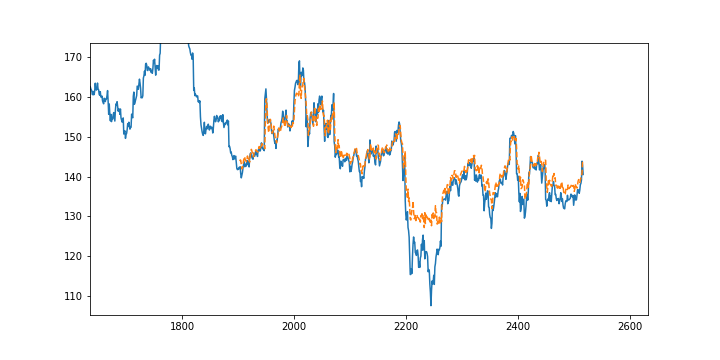

In [32]:
%matplotlib notebook
plt.figure(figsize=[10,5])
plot_pred(model)

__Comment:__<br>
The predictions are the dotted lines and the actuals price are in solid lines. We can see that the model does a great job to predict the daily stock price; however, between the index 2200 to 2300, the model does not catch the patterns well. Let's make some improvement.

In [27]:
model2 = Sequential()
model2.add(Reshape((look_back,1), input_shape=(look_back,)))
model2.add(SimpleRNN(64))
model2.add(Reshape((64, 1), input_shape = (64,)))
model2.add(Conv1D(10, 3, activation='tanh'))
model2.add(Flatten())
model2.add(Dropout(0.25))
model2.add(Dense(1))
model2.add(Activation('linear'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 15, 1)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
reshape_2 (Reshape)          (None, 64, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 62, 10)            40        
_________________________________________________________________
flatten (Flatten)            (None, 620)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 620)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [28]:
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2, validation_split=0.1)

Train on 1699 samples, validate on 189 samples
Epoch 1/5
1699/1699 - 4s - loss: 0.0071 - val_loss: 0.0020
Epoch 2/5
1699/1699 - 4s - loss: 0.0027 - val_loss: 0.0015
Epoch 3/5
1699/1699 - 5s - loss: 0.0024 - val_loss: 0.0010
Epoch 4/5
1699/1699 - 4s - loss: 0.0027 - val_loss: 8.1197e-04
Epoch 5/5
1699/1699 - 4s - loss: 0.0022 - val_loss: 4.4870e-04


<IPython.core.display.Javascript object>


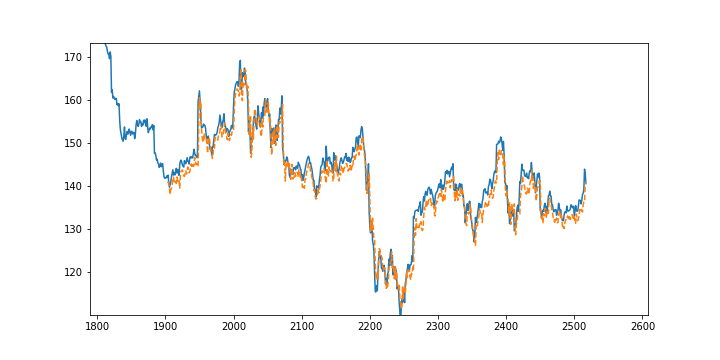

In [33]:
%matplotlib notebook
plt.figure(figsize=[10,5])
plot_pred(model2)

From the above plot, we can see that model2 does a much better job to catch the patterns and predict the daily stock price.  